# t-SNE Analysis

This notebook illustrate how to analyze IDP ensembles in IDPET via [t-distributed stochastic neighbor embedding](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) (t-SNE) implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

## Load data from PED

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dpet.ensemble import Ensemble
from dpet.ensemble_analysis import EnsembleAnalysis
from dpet.visualization import Visualization
from dpet.utils import set_verbosity


set_verbosity("INFO")  # Change verbosity level to show more information when performing the analysis.

np.random.seed(2025)  # Set the random seed for reproducibility.

ens_codes = [
    Ensemble('PED00156e001', database='ped'),
    Ensemble('PED00157e001', database='ped'),
    Ensemble('PED00158e001', database='ped') 
]

data_dir = None  # Add the path to a directory you wish in order to save the analysis
analysis = EnsembleAnalysis(ens_codes, output_dir=data_dir)
analysis.load_trajectories()

Ensemble PED00156e001 already downloaded. Skipping.
File PED00156e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00156e001.
Ensemble PED00157e001 already downloaded. Skipping.
File PED00157e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00157e001.
Ensemble PED00158e001 already downloaded. Skipping.
File PED00158e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00158e001.
Loading trajectory for PED00156e001...
Loading trajectory for PED00157e001...
Loading trajectory for PED00158e001...


{'PED00156e001': <mdtraj.Trajectory with 100 frames, 941 atoms, 59 residues, without unitcells at 0x148db56f0>,
 'PED00157e001': <mdtraj.Trajectory with 100 frames, 939 atoms, 59 residues, without unitcells at 0x1498f3df0>,
 'PED00158e001': <mdtraj.Trajectory with 88 frames, 939 atoms, 59 residues, without unitcells at 0x148e0bee0>}

In [2]:
# Subsample the ensembles by randomly selecting 50 snapshots from each.
analysis.random_sample_trajectories(sample_size=50);

50 conformations sampled from PED00156e001 trajectory.
50 conformations sampled from PED00157e001 trajectory.
50 conformations sampled from PED00158e001 trajectory.


## Featurization

Represent molecular conformations as their set of Ca-Ca distances.

In [3]:
analysis.extract_features(featurization='ca_dist');

Performing feature extraction for Ensemble: PED00156e001.
Transformed ensemble shape: (50, 1653)
Performing feature extraction for Ensemble: PED00157e001.
Transformed ensemble shape: (50, 1653)
Performing feature extraction for Ensemble: PED00158e001.
Transformed ensemble shape: (50, 1653)


## Dimensionality Reduction

Perform t-SNE.

In [4]:
analysis.reduce_features(
    method='tsne',
    perplexity_vals=[10, 20,  50, 100],
    circular=False,
    range_n_clusters=range(2,10,1),
    random_state=2025
);

Concatenated featurized ensemble shape: (150, 1653)
tsne is running...
Best Perplexity: 20
Best Number of Clusters: 3
Silhouette Score Low Dimensional: 0.5932091474533081
Silhouette Score High Dimensional: 0.25773754715919495
Silhouette Score Product: 0.15289227061701283
Reduced dimensionality ensemble shape: (50, 2)
Reduced dimensionality ensemble shape: (50, 2)
Reduced dimensionality ensemble shape: (50, 2)


## Analysis

In [5]:
vis = Visualization(analysis)

The preferred and comprehensive method for easily visualizing t-SNE results is `dimensionality_reduction_scatter`.

It will show three scatterplots where each datapoint represent a conformation embedded in a 2d space. The scatterplots show conformations colored according to:
* Their original ensemble (**original labels**).
* Their cluster identified during the hyper-parameter selection scheme of t-SNE (**clustering labels**).
* The value of one of these molecular features: "rg", "prolateness", "asphericity", "sasa", and "end_to_end".

The method will also show:
* A kernel density estimate (KDE) of the distribution of the embedded conformations.
* Optional, an interactive 2d plot created with the plotly library with conformations colored according to the selected molecular feature.

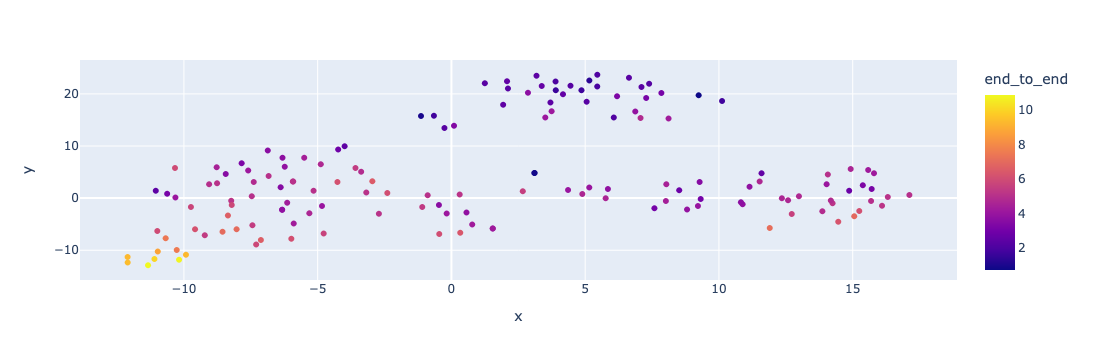

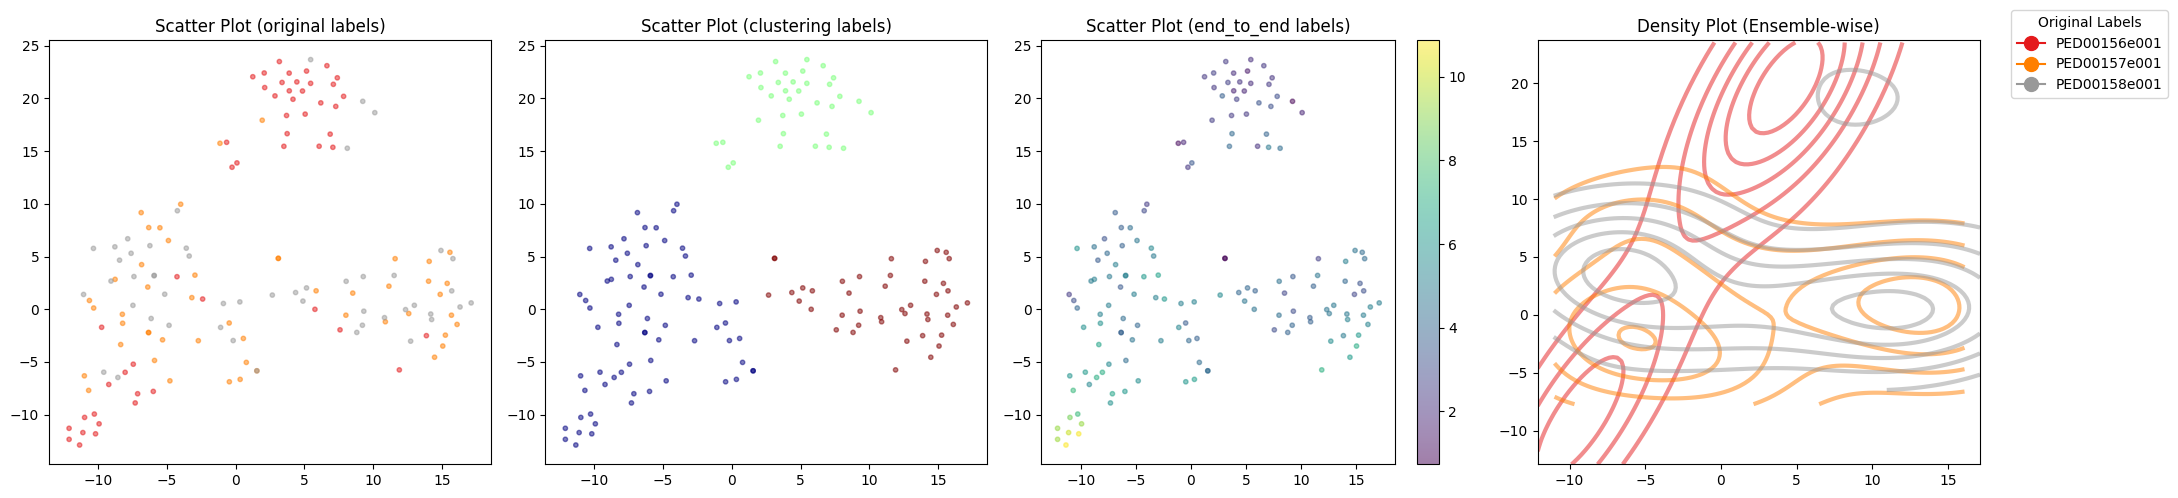

In [6]:
vis.dimensionality_reduction_scatter(
    color_by="end_to_end",  # Color the snapshots according to a molecular feature, here end-to-end distance.
    kde_by_ensemble=True,   # In the subplot with KDE, show data for the individual ensembles. 
    plotly=True             # Interactive visualization using plotly.
);

We can also directly access the t-SNE features, in case we want to produce custom plots.

We illustrate this scenario below.

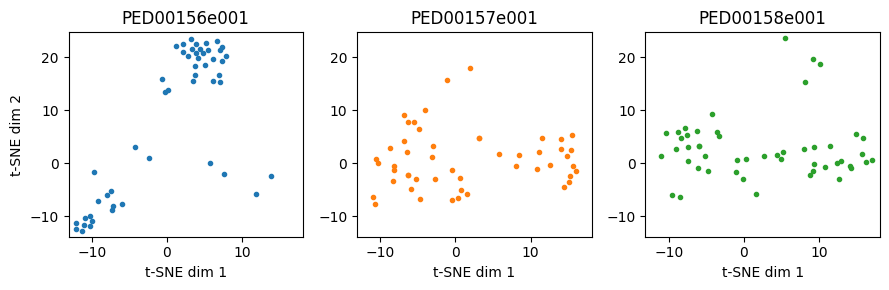

In [7]:
# Create a custom plot with the t-SNE features calculated via the IDPET API.
num_ensembles = len(analysis.ensembles)

fig, ax = plt.subplots(1, len(analysis.ensembles), figsize=(num_ensembles*3, 3))
concat_ens = np.concatenate([e.reduce_dim_data for e in analysis.ensembles], axis=0)
margin = 1.0
for i, ensemble in enumerate(analysis.ensembles):
    tsne_data = ensemble.reduce_dim_data
    ax[i].scatter(tsne_data[:,0], tsne_data[:,1], marker=".", color=f"C{i}")
    ax[i].set_title(ensemble.code)
    ax[i].set_xlabel("t-SNE dim 1")
    if i == 0:
        ax[i].set_ylabel("t-SNE dim 2")
    ax[i].set_xlim(concat_ens[:,0].min()-margin, concat_ens[:,0].max()+margin)
    ax[i].set_ylim(concat_ens[:,1].min()-margin, concat_ens[:,1].max()+margin)
plt.tight_layout()
plt.show()